# Домашняя работа (Градиентный бустинг)

### Задание 1: Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
from metrics import Metrics

import matplotlib.pyplot as plt
import numpy as np

In [37]:
class GradientBoosting:
    def __init__(self,
                 eta=0.1,
                 model_coef_list=None,
                 base_model=DecisionTreeRegressor,
                 count_base_model=5,
                 base_model_params=None,
                 error_function_name='MSE'):
        """
        Конструктор модели
        :param eta: скорость обучения
        :param model_coef_list: список весовыз коэффициентов базовых функиий
        :param base_model: класс базовой модели
        :param count_base_model: количество базовых моделей
        :param base_model_params: параметры базовой модели
        :param error_function_name: функция ошибки. В данной версии доступна только MSE
        """

        if not base_model_params:
            base_model_params = {'max_depth': 5}

        self.eta = eta
        self.model_coef_list = model_coef_list if model_coef_list else [1] * count_base_model

        self.count_base_model = count_base_model
        self.base_model = base_model
        self.base_model_params = base_model_params

        if error_function_name == 'MSE':
            self.error_function = Metrics.mse
            self.error_function_name = error_function_name

        self.base_model_list = list()

    def __bias(self, true_value, predict_value):
        """
        Функция возвращает смещение посчитаниое как градиент от функции ошибок
        :param true_value: Правильные ответы
        :param predict_value: Предсказанные значения
        :return: значения смечения
        """
        if self.error_function_name == 'MSE':
            return true_value - predict_value

    def _fit_base_model(self, X_train, y_train, X_test, y_test, visualization):
        """
        Метод для обучения модели на выборке данных и расчета ошибки
        :param X_train: Обучающая выборка признаков
        :param y_train: Обучающая целевая переменная
        :param X_test: Тестовая выборка признаков
        :param y_test: Тесновая целевая переменная
        :param visualization: Флаг для визуализации результатов обучения
        :return: Обученая модель, ошибка на train и test
        """

        model = self.base_model(**self.base_model_params)
        train_error = 0
        test_error = 0
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль,
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список

        if len(self.base_model_list) == 0:
            # обучаем первое дерево на обучающей выборке
            model.fit(X_train, y_train)
        else:
            # Получим ответы на текущей композиции
            new_target = self.predict(X_train)

            # алгоритмы начиная со второго обучаем на сдвиг
            model.fit(X_train, self.__bias(y_train, new_target))

        train_error = self.error_function(y_train, self.predict(X_train))

        if visualization:
            test_error = self.error_function(y_test, self.predict(X_test))

        return model, train_error, test_error

    def fit(self, X_train, y_train, X_test=None, y_test=None, visualization=False):
        """
        Метод для обучения модель
        :param X_train: обучающий набор данных
        :param y_train: набор целевых значений обучающего набора данных
        :param visualization: флаг визуализации процесса обучения
        :param X_test: тестовый набор данных (используется, если установлен флаг visualization)
        :param y_test: набор целевых значений тестового набора данных (используется, если установлен флаг visualization)
        :return: Ошибки при обучении
        """

        # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
        train_errors = []
        test_errors = []
        self.base_model_list = list()

        for i in range(self.count_base_model):

            model, train_error, test_error = self._fit_base_model(X_train, y_train, X_test, y_test, visualization)

            train_errors.append(train_error)

            if visualization:
                # test_errors.append(self.error_function(y_test, self.predict(X_test)))
                test_errors.append(test_error)

            self.base_model_list.append(model)

        if visualization:
            plt.figure(figsize=(8, 6))
            plt.title(f'Train error is {train_errors[-1]}, test error is {test_errors[-1]}')
            plt.xlabel('Iteration number')
            plt.ylabel(self.error_function_name)
            plt.xlim(0, self.count_base_model + 1)
            plt.plot(list(range(1, self.count_base_model + 1)), train_errors, label='train error')
            plt.plot(list(range(1, self.count_base_model + 1)), test_errors, label='test error')
            plt.scatter(list(range(1, self.count_base_model + 1)), train_errors)
            plt.scatter(list(range(1, self.count_base_model + 1)), test_errors)
            plt.legend(loc='upper right')
            plt.show()

        return train_errors, test_errors

    def predict(self, X):
        """
        Метод для предсказания значения целевой переменной
        :param X: входные данные
        :return: целевая переменная
        """
        
        return np.array(
            [sum([self.eta * coef * alg.predict([x])[0] for alg, coef in
                  zip(self.base_model_list, self.model_coef_list)]) for x in X])

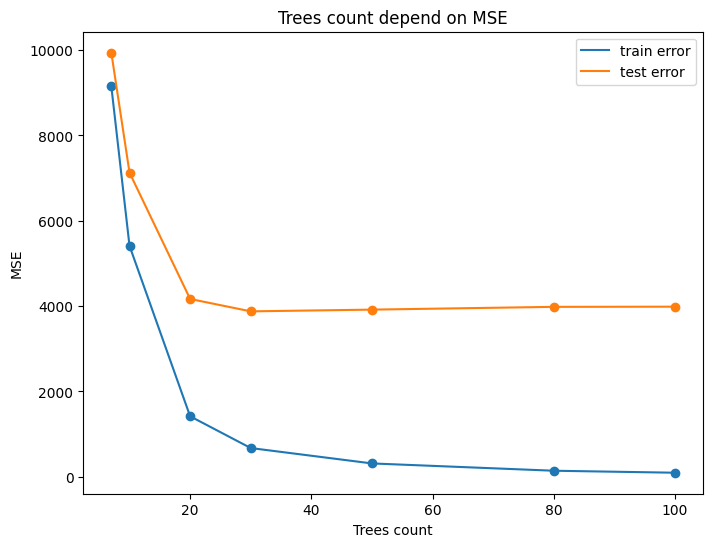

In [17]:
n_trees = [7, 10, 20, 30, 50, 80, 100]
train_errors = list()
test_errors = list()
for trees in n_trees:
    # print(trees)
    model = GradientBoosting(eta=0.1,
                             count_base_model=trees)
    train_errors.append(model.fit(X_train, y_train)[0][-1])
    test_errors.append(Metrics.mse(y_test, model.predict(X_test)))

plt.figure(figsize=(8, 6))
plt.title(f'Trees count depend on MSE')
plt.xlabel('Trees count')
plt.ylabel('MSE')
plt.plot(n_trees, train_errors, label='train error')
plt.plot(n_trees, test_errors, label='test error')
plt.scatter(n_trees, train_errors)
plt.scatter(n_trees, test_errors)
plt.legend(loc='upper right')
plt.show()

Из графика видно, что ошибка на train падает не постоянно. Имеется минимум. В данном случае он имеет значение 30

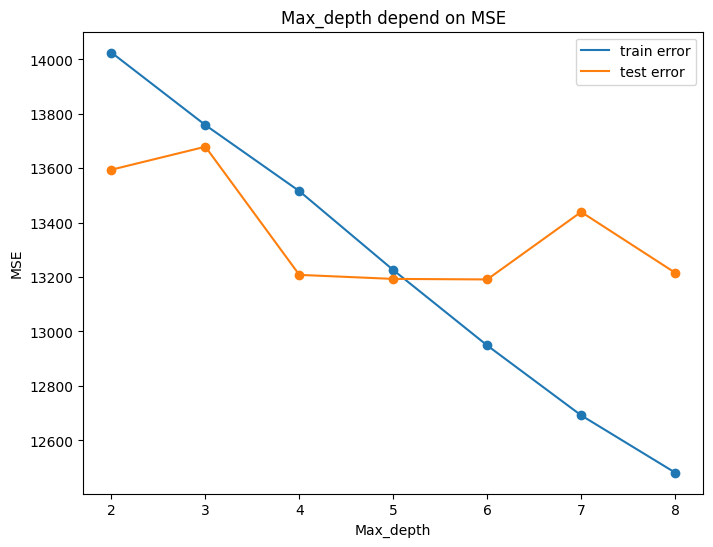

In [24]:
# trees_depth = np.linspace(2, 8, num=5, endpoint=True, dtype=int)
trees_depth = [2, 3, 4, 5, 6, 7, 8]
train_errors = list()
test_errors = list()
for tree_depth in trees_depth:
    # print(trees)
    model = GradientBoosting(eta=0.1,
                             base_model_params={'max_depth': tree_depth})
    train_errors.append(model.fit(X_train, y_train)[0][-1])
    test_errors.append(Metrics.mse(y_test, model.predict(X_test)))

plt.figure(figsize=(8, 6))
plt.title(f'Max_depth depend on MSE')
plt.xlabel('Max_depth')
plt.ylabel('MSE')
plt.plot(trees_depth, train_errors, label='train error')
plt.plot(trees_depth, test_errors, label='test error')
plt.scatter(trees_depth, train_errors)
plt.scatter(trees_depth, test_errors)
plt.legend(loc='upper right')
plt.show()

Из графика видно, что ошибка минимальна при Max_depth равном 6. Таим образом модель будет иметь минимальную ошибку на train при count_base_model=30 и max_depth=5. Интересно проверить так ли это, существует ли взаимное влияние одного признака на другой

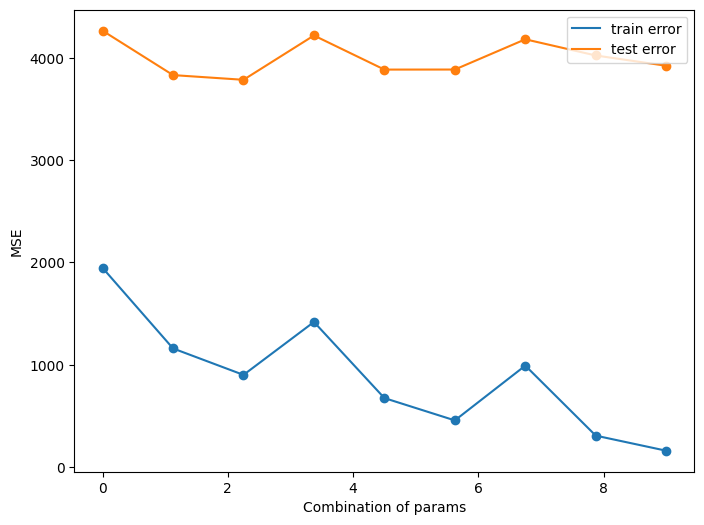

In [34]:
combination_of_param = np.array(np.meshgrid(trees_depth, n_trees)).T.reshape(-1, 2)
n_trees = [20, 30, 40]
trees_depth = [4, 5, 6]

train_errors = list()
test_errors = list()
for i in range(len(combination_of_param)):
    model = GradientBoosting(eta=0.1,
                             base_model_params={'max_depth': combination_of_param[i][0]}, 
                             count_base_model=combination_of_param[i][1])
    train_errors.append(model.fit(X_train, y_train)[0][-1])
    test_errors.append(Metrics.mse(y_test, model.predict(X_test)))

plt.figure(figsize=(8, 6))
# plt.title(f'Max_depth depend on MSE')
plt.xlabel('Combination of params')
plt.ylabel('MSE')
plt.plot(np.linspace(0, len(combination_of_param), num=len(combination_of_param)), train_errors, label='train error')
plt.plot(np.linspace(0, len(combination_of_param), num=len(combination_of_param)), test_errors, label='test error')
plt.scatter(np.linspace(0, len(combination_of_param), num=len(combination_of_param)), train_errors)
plt.scatter(np.linspace(0, len(combination_of_param), num=len(combination_of_param)), test_errors)
plt.legend(loc='upper right')
plt.show()

In [35]:
combination_of_param[2]


array([ 4, 40])

Видно, что минимальная ошибка на трейне достигается при max_depth=4 и count_base_model=40. Таким образом видно, что параметры влияют друг на друга 

### Задание 2: (опция) . Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [38]:
class StochasticGradientBoosting(GradientBoosting):
    def __init__(self,
                 eta=0.1,
                 model_coef_list=None,
                 base_model=DecisionTreeRegressor,
                 count_base_model=30,
                 base_model_params=None,
                 error_function_name='MSE',
                 subsample_coef=0.5):
        """
        Конструктор модели
        :param eta: скорость обучения
        :param model_coef_list: список весовыз коэффициентов базовых функиий
        :param base_model: класс базовой модели
        :param count_base_model: количество базовых моделей
        :param base_model_params: параметры базовой модели
        :param error_function_name: функция ошибки. В данной версии доступна только MSE
        :param subsample_coef: Размер банча в относительных единицах
        """

        super(StochasticGradientBoosting, self).__init__(eta, model_coef_list, base_model, count_base_model,
                                                         base_model_params, error_function_name)
        self.subsample_coef = subsample_coef

        return

    def _fit_base_model(self, X_train, y_train, X_test, y_test, visualization):
        """
        Метод для обучения модели на выборке данных и расчета ошибки для стахостического градиентного бустинга
        :param X_train: Обучающая выборка признаков
        :param y_train: Обучающая целевая переменная
        :param X_test: Тестовая выборка признаков
        :param y_test: Тесновая целевая переменная
        :param visualization: Флаг для визуализации результатов обучения
        :return: Обученая модель, ошибка на train и test
        """
        full_samples = X_train.shape[0]
        sub_samples_index = np.random.choice(full_samples, size=int(self.subsample_coef * full_samples),
                                             replace=False)
        return super(StochasticGradientBoosting, self)._fit_base_model(X_train[sub_samples_index, :],
                                                                       y_train[sub_samples_index],
                                                                       X_test,
                                                                       y_test,
                                                                       visualization)

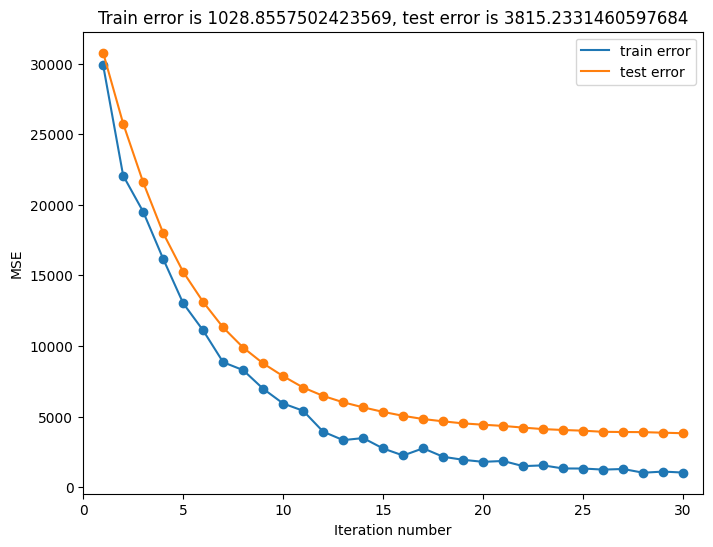

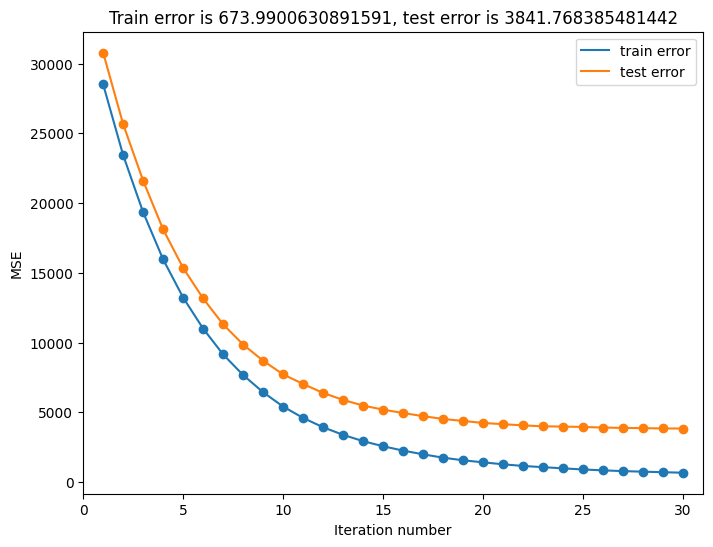

In [50]:
model = StochasticGradientBoosting()
stachastic_train_error, stachastic_test_error = model.fit(X_train, y_train, X_test, y_test, visualization=True)

model = GradientBoosting(count_base_model=30)
train_error, test_error = model.fit(X_train, y_train, X_test, y_test, visualization=True)

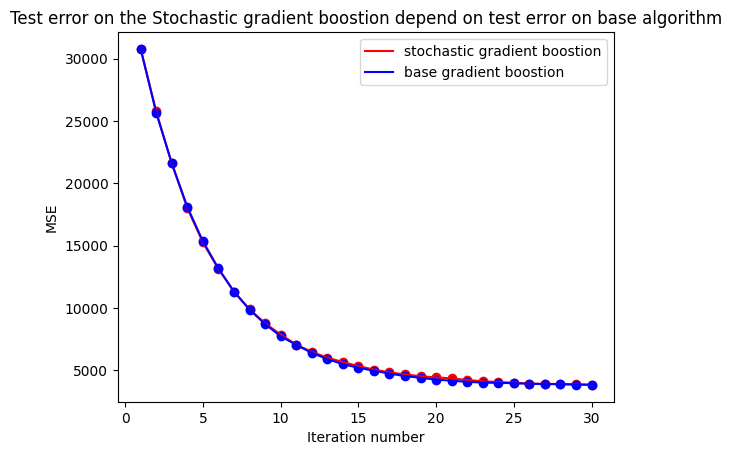

In [55]:
plt.figure()
plt.title('Test error on the Stochastic gradient boostion depend on test error on base algorithm')
plt.plot(list(range(1, len(stachastic_test_error) + 1)), stachastic_test_error, c='red',
         label='stochastic gradient boostion')
plt.scatter(list(range(1, len(stachastic_test_error) + 1)), stachastic_test_error, c='red')
plt.plot(list(range(1, len(test_error) + 1)), test_error, c='blue', label='base gradient boostion')
plt.scatter(list(range(1, len(test_error) + 1)), test_error, c='blue')
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.show()

В конечном счете ошибка на стахостическом градиентном бустинге оказалась меньше, чем на обычном, но незначительно. Процесс обучения на стахостическом градиентном бустинге менее плавный, чем в обычном градиентном бустинге

### Задание 3:(опция). Реализовать алгоритм градиетного бустинга, основанный на реализации решающего дерева из ДЗ4 / методички к уроку 4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

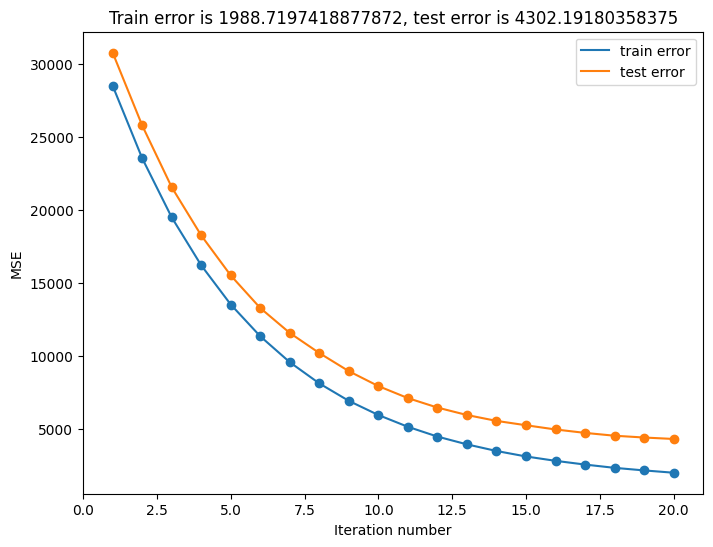

In [41]:
import decision_tree as my_tree

model = GradientBoosting(base_model=my_tree.DecisionTreeRegression,
                             base_model_params={'quality': my_tree.Quality(inform_criterion_method='variance'),
                                                'max_depth': 4},
                             count_base_model=20)
my_tree_train_error, my_tree_test_error = model.fit(X_train, y_train, X_test, y_test, visualization=True)

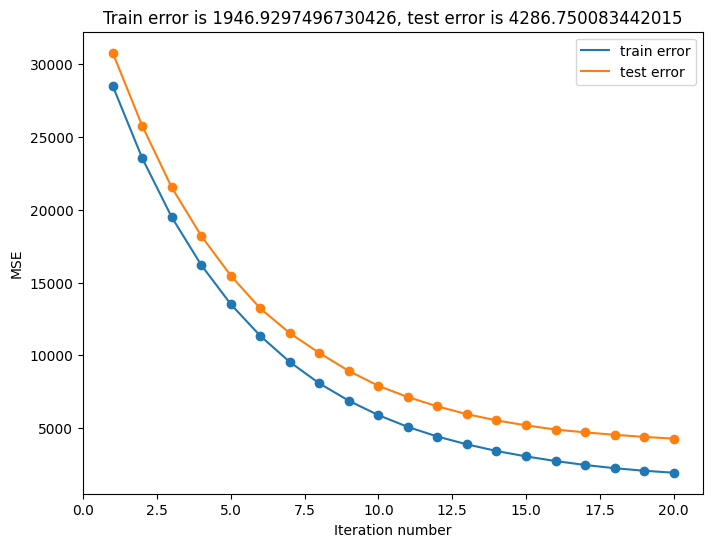

In [42]:
model = GradientBoosting(count_base_model=20, 
                        base_model_params={'max_depth': 4})
sklearn_train_error, sklearn_test_error = model.fit(X_train, y_train, X_test, y_test, visualization=True)

При использовании, в качестве базовой модели, реализацию дерева из sklearn, ошибка на test меньше, чем при использовании собственного дерева. 